In [1]:
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import einops.layers.torch as elt
import einops

import matplotlib.pyplot as plt

figsize = (12, 10)
fontsize_figure = 16
fontsize_plot = 12
fontsize_axis = 10
dpi=75

# Patch operation

The patch embedding and the patch merge modules are almost identical. The original Swin Transformer implementation made
a difference regarding the implementation. For the embedding process, they utilised a 2d convolution layer. For  
patch merging, they concatenated a patch along the embedding dimension. Afterwards, a linear projection
is applied to get the new embedding dimension.

![patch operation](../images/patch-operation.png)

Nonetheless, technically, one can employ both strategies depending on the problem. The difference is the number of
learnable parameters. Consider the following example:

- in_channels = $128$, out_channels = $64$, kernel_size = $(2, 2)$
- param_linr = $128 \cdot 64 + 64 = 8256$
- param_conv = $128 \cdot 64 \cdot (2 \cdot 2) + 64 = 32832$

As one can see, the parameter count differs significantly. However, the additional parameter of a convolutional layer
might help a model to learn the spatial relationship within a patch and provide a more sophisticated representation.
The most challenging part is the rearrangement of multi-dimensional tensors (at least for me). First, we require the
correct torch function to rearrange and concatenate the tensors or perform clever slicing. Alternatively, one 
imports a library called _einops_, which allows us to perform multi-dimensional tensor manipulation in a readable
format. Regardless, once implemented, one uses it throughout the project.

```py
# With PyTorch native
b, c, h, w = image.shape
hm, wm = 2, 2
hdm, wdm = h // hm, w // wm
image = image # (b, c, h, w)
image = image.unfold(-2, hm, hm)  # (b, c, hdm, w, hm)
image = image.unfold(-2, wm, wm)  # (b, c, hdm, wdm, hm, wm)
image = image.reshape(b, hdm, wdm, c * hm * wm)

# Or with Einops
from einops import rearrange
image = rearrange(image, "b c (hdm hm) (wdm wm) -> b hdm wdm (c hm wm)", hm=hm, wm=wm)

# Or even TorchScript compatible
from einops.layers.torch import Rearrange
image = Rearrange("b c (hdm hm) (wdm wm) -> b hdm wdm (c hm wm)", hm=hm, wm=wm)(image)
```

<style type="text/css">img { width: 80ch; }</style>

In [2]:
torch.manual_seed(0)

# Parameters of a layer
h, w = (6, 8)
hm, wm = (2, 2)
c = 3 or 1
c_embed = 12
hdm, wdm = h // hm, w // wm

# Input can be an image or a sequence
image_spt = torch.randn(1, c, h, w)
image_spt = image_spt / image_spt.max()
image_seq = einops.rearrange(image_spt, "b c h w -> b (h w) c")

print("Input")
print(f"'b c h w'   = {tuple(image_spt.shape)}")
print(f"'b (h w) c' = {tuple(image_seq.shape)}")
print()

# The rearrange operations and the projection
# Note: the convolutional projection is basically a window which we shift by
#       its size to get the patches
rearrange_input_spt = elt.Rearrange("b c h w -> b c h w", h=h, w=w)
rearrange_input_seq = elt.Rearrange("b (h w) c -> b c h w", h=h, w=w)
rearrange_output = elt.Rearrange("b c h w -> b (h w) c", h=hdm, w=wdm)
projection = nn.Conv2d(c, c_embed, kernel_size=(hm, wm), stride=(hm, wm))

# For the sake of the visualisation
patches = einops.rearrange(image_spt, "b c (hdm hm) (wdm wm) -> b hdm wdm hm wm c", hm=hm, wm=wm)

# The forward pass
patches_projected_spt = projection(rearrange_input_spt(image_spt))
patches_projected_seq = projection(rearrange_input_seq(image_seq))

print("Projection")
print(f"'b c hdm wdm' = {tuple(patches_projected_spt.shape)}")
print(f"'b c hdm wdm' = {tuple(patches_projected_seq.shape)}")
print()

# Rearrange the output
patches_projected_spt_out = rearrange_output(patches_projected_spt)
patches_projected_seq_out = rearrange_output(patches_projected_seq)

print("Output")
print(f"'b (h w) c' = {tuple(patches_projected_spt_out.shape)}")
print(f"'b (h w) c' = {tuple(patches_projected_seq_out.shape)}")
print()

print(f"Are the outputs equal? {torch.all(patches_projected_spt_out == patches_projected_seq_out)}")

Input
'b c h w'   = (1, 3, 6, 8)
'b (h w) c' = (1, 48, 3)

Projection
'b c hdm wdm' = (1, 12, 3, 4)
'b c hdm wdm' = (1, 12, 3, 4)

Output
'b (h w) c' = (1, 12, 12)
'b (h w) c' = (1, 12, 12)

Are the outputs equal? True


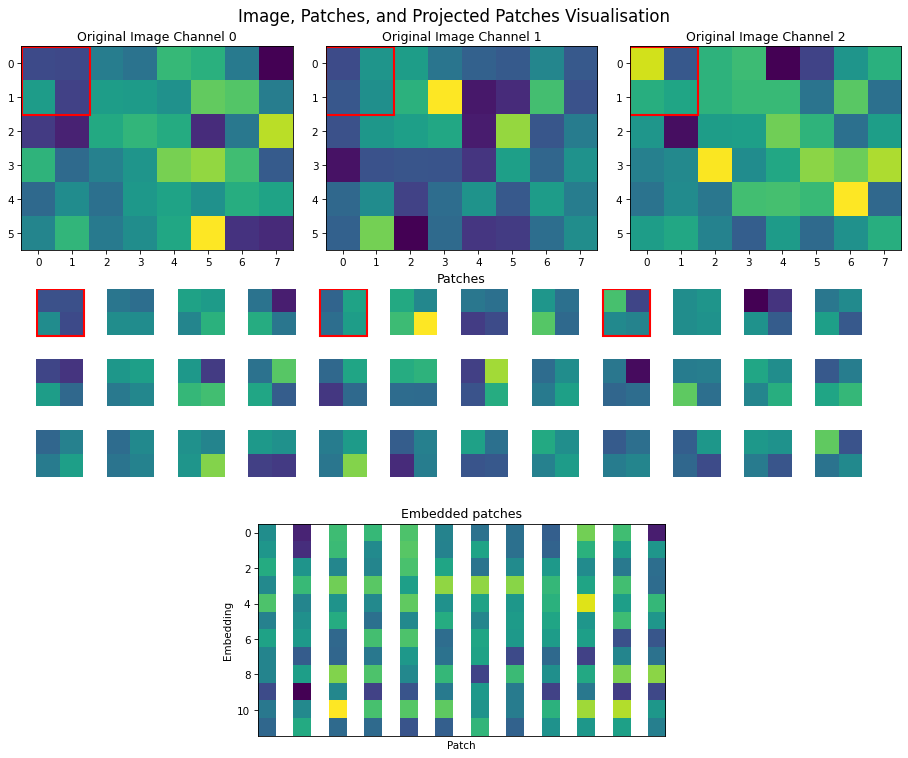

In [3]:
fig = plt.figure(constrained_layout=True, figsize=figsize, dpi=dpi)
fig.suptitle("Image, Patches, and Projected Patches Visualisation", fontsize=fontsize_figure)

gs = fig.add_gridspec(3, c)

for i in range(0, c):
    ax = fig.add_subplot(gs[0, i])
    img = image_spt.squeeze(0)
    ax.imshow(img[i].detach().numpy())
    ax.set_title(f"Original Image Channel {i}", fontsize=fontsize_plot)
    ax.add_patch(plt.Rectangle((-0.49, -0.49), wm, hm, edgecolor="red", linewidth=2, facecolor="none"))

ax = fig.add_subplot(gs[1, :])
img_patches = patches.squeeze(0)
img_patches = nnf.pad(img_patches, (0, 0, 0, 1, 0, 1), value=torch.nan)
img_patches = einops.rearrange(img_patches, "hdm wdm hm wm c -> (hdm hm) (c wdm wm)")
ax.imshow(img_patches.detach().numpy())
ax.set_title("Patches", fontsize=fontsize_plot)
ax.axis("off")
for i in range(0, c):
    ax.add_patch(
        plt.Rectangle((i * (wm + 1) * wdm - 0.49, -0.49), wm, hm, edgecolor="red", linewidth=2, facecolor="none")
    )

ax = fig.add_subplot(gs[2, :])
ob, on, oc = patches_projected_spt_out.shape
img_embed = patches_projected_spt_out.contiguous().view(-1).contiguous()
img_embed = nnf.pad(img_embed, (0, on * oc), value=torch.nan).view(2, on * oc)
img_embed = einops.rearrange(img_embed, "k (on oc) -> oc (on k)", k=2, on=on, oc=oc)
ax.imshow(img_embed[:, :-1].detach().numpy())
ax.set_title("Embedded patches", fontsize=fontsize_plot)
ax.set_xlabel("Patch", fontsize=fontsize_axis)
ax.set_ylabel("Embedding", fontsize=fontsize_axis)
ax.set_xticks([])

plt.show()
plt.close()

# Window attention

The Swin Transformer, as the name suggests, contains self-attention mechanisms
that was multi-head self-attention, which was introduced with the _"Attention is 
all you need"_ paper. 

$$
[\mathbf{Q},\mathbf{K},\mathbf{V}] = \mathbf{X}\mathbf{U} 
$$
$$
\mathbf{Z} = \mathbf{A} \mathbf{V}, \quad
\mathbf{A} = softmax \left(\frac{\mathbf{Q}\mathbf{K}^\top + \mathbf{b}_{rel}}{\sqrt{d_k}} \right)
$$

One can interpret the equation as a global attention scheme, as all elements in
a sequence are attended for each element, leading to the $\mathcal{O}(n^2)$ runtime. In
computer vision, one works with images or volumes that undergo the previously
mentioned patching computation. The issue is that selecting a small patch
size causes a significant quadratic scaling of the input; for instance, 
considering a patch size of one would yield an input sequence of $H \cdot W$.
Hence, Liu et al. decided to employ a local attention scheme. They had the idea
to group the patch into an $M \times M$ window. Within this window, one computes the
self-attention, limiting the computation to $(M \times M)^2$. Of course, one has
to apply self-attention to each window, yielding $N \times (M \times M)^2$ for
local and $N \times N$ for global self-attention. The former is computationally
more efficient if the selected $M$ (window size) is significantly smaller than 
$N$ (number of patches).

$$
\frac{H}{M_h} * \frac{W}{M_w} \quad where \quad H, W \gg M_h, M_w
$$

As one might have noticed, before computing the attention weight with the softmax,
we add a vector of biases $\mathbf{b}_{rel}$ to the attention score. The bias is a
relative positional embedding. Technically, it is a parametrised relative positional
bias for the Swin Transformer, but one can employ different valid embedding
strategies depending on the task at hand.

![relative positional embedding](../images/relative-positional-embedding-bias.png)

One applies self-attention to local windows with the addition of relative
positional embeddings. Processing the windows sequentially would be highly
inefficient, although a parallel computation is feasible because the windows
are disjointed patches. The clever approach is to rearrange the input so that
the number of windows becomes the new batch dimension.

![window batching](../images/window-batching.png)

By batching the windows, we can exploit a framework's parallel processing; see
PyTorch or TensorFlow. After the computation, we can rearrange the output to
separate the batch dimension again.

Recall that the windows are disjointed, and the self-attention is too.
Accordingly, to capture intra-window relationships, Liu et al. propose to 
shift the attention window by $\lfloor{\frac{m}{2}}\rfloor$ where $m$ is the 
window size. This allows adjacent windows to consider their neighbours in a
semantic representation.

However, intra-window attention has two problems. The windows at the edges
of an image or volume are smaller than ordinary windows. This requires special 
treatment with techniques like padding, which leads to more windows in total, 
causing additional computation.
Therefore, the author suggested shifting the window in both axes by $\lfloor{\frac{m}{2}}\rfloor$, handling the windows at the edges and keeping the number of windows for an image constant.

![window shifting](../images/window-shift.png)

Finally, some windows contain elements which are not adjacent (see the illustration of the colours). Therefore, we must perform masking to avoid attention computation of non-adjacent entries. Note that we can pre-compute the mask for efficient processing.

<style type="text/css">img { width: 80ch; }</style>

## Window batching and shifting

In [4]:
h, w = 4, 4
hm, wm = 2, 2
hdm, wdm = h // hm, w // wm
c = 1

windows_batching = (
    torch.tensor([[0, 0, 1, 1], [0, 0, 1, 1], [2, 2, 3, 3], [2, 2, 3, 3]])
    .view(-1)
    .unsqueeze(0)
    .unsqueeze(-1)
    .contiguous()
)
windows_shifting = (
    torch.tensor([[0, 1, 1, 2], [3, 4, 4, 5], [3, 4, 4, 5], [6, 7, 7, 8]])
    .view(-1)
    .unsqueeze(0)
    .unsqueeze(-1)
    .contiguous()
)

print("Images")
print(f"'b (h w) c' = {tuple(windows_batching.shape)}")
print(f"'b (h w) c' = {tuple(windows_shifting.shape)}")

windows_shifting_rolled = windows_shifting.view(1, h, w, 1).roll((-hm // 2, -wm // 2), dims=(1, 2)).view(1, -1, 1)

windows_batching_windowed = einops.rearrange(
    windows_batching, "b (hdm hm wdm wm) c -> (b hdm wdm) hm wm c", hdm=hdm, hm=hm, wdm=wdm, wm=wm
)
windows_shifting_windowed = einops.rearrange(
    windows_shifting_rolled, "b (hdm hm wdm wm) c -> (b hdm wdm) hm wm c", hdm=hdm, hm=hm, wdm=wdm, wm=wm
)

print("Windows")
print(f"'(b hdm wdm) hm wm c' = {tuple(windows_batching_windowed.shape)}")
print(f"'(b hdm wdm) hm wm c' = {tuple(windows_shifting_windowed.shape)}")

Images
'b (h w) c' = (1, 16, 1)
'b (h w) c' = (1, 16, 1)
Windows
'(b hdm wdm) hm wm c' = (4, 2, 2, 1)
'(b hdm wdm) hm wm c' = (4, 2, 2, 1)


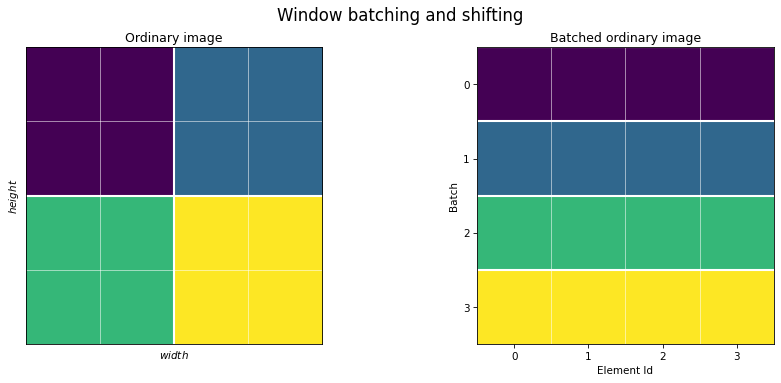

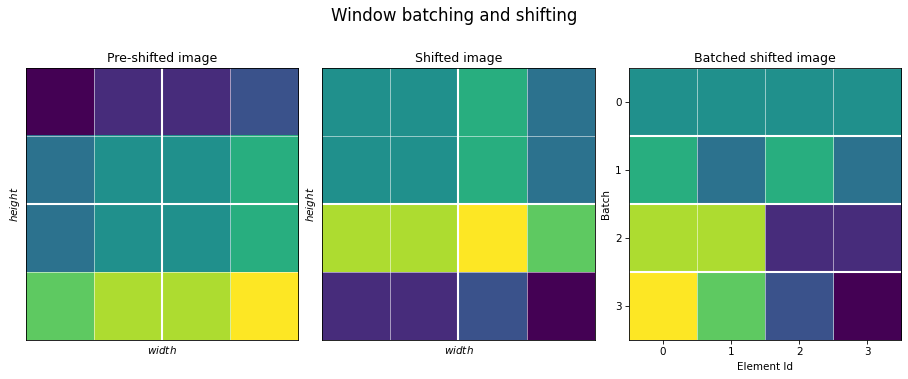

In [5]:
figsize = (12, 5)
fig = plt.figure(constrained_layout=True, figsize=figsize, dpi=dpi)
fig.suptitle("Window batching and shifting", fontsize=fontsize_figure)
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, 0])
ax.imshow(windows_batching.squeeze(0).squeeze(-1).view(h, w).detach().numpy())
ax.set_title("Ordinary image")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$width$")
ax.set_ylabel(r"$height$")
ax.axvline(hm - 0.5, color="#fff", linewidth=2)
ax.axhline(wm - 0.5, color="#fff", linewidth=2)
for i in range(1, hdm + 2):
    ax.axhline(i - 0.5, color="#fff", linewidth=0.5)
for i in range(1, wdm + 2):
    ax.axvline(i - 0.5, color="#fff", linewidth=0.5)

ax = fig.add_subplot(gs[0, 1])
ax.imshow(windows_batching_windowed.squeeze(-1).view(-1, w).detach().numpy())
ax.set_title("Batched ordinary image")
ax.set_xticks(range(0, hm * wm))
ax.set_yticks(range(0, hdm * wdm))
ax.set_xlabel("Element Id")
ax.set_ylabel("Batch")
for i in range(0, hm * wm):
    ax.axvline(i - 0.5, color="#fff", linewidth=0.5)
for i in range(0, hdm * wdm):
    ax.axhline(i - 0.5, color="#fff", linewidth=2)

plt.show()

fig = plt.figure(constrained_layout=True, figsize=figsize, dpi=dpi)
fig.suptitle("Window batching and shifting", fontsize=fontsize_figure)
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
ax.imshow(windows_shifting.squeeze(0).squeeze(-1).view(h, w).detach().numpy())
ax.set_title("Pre-shifted image")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$width$")
ax.set_ylabel(r"$height$")
ax.axvline(hm - 0.5, color="#fff", linewidth=2)
ax.axhline(wm - 0.5, color="#fff", linewidth=2)
for i in range(1, hdm + 2):
    ax.axhline(i - 0.5, color="#fff", linewidth=0.5)
for i in range(1, wdm + 2):
    ax.axvline(i - 0.5, color="#fff", linewidth=0.5)

ax = fig.add_subplot(gs[0, 1])
ax.imshow(windows_shifting_rolled.squeeze(0).squeeze(-1).view(h, w).detach().numpy())
ax.set_title("Shifted image")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$width$")
ax.set_ylabel(r"$height$")
ax.axvline(hm - 0.5, color="#fff", linewidth=2)
ax.axhline(wm - 0.5, color="#fff", linewidth=2)
for i in range(1, hdm + 2):
    ax.axhline(i - 0.5, color="#fff", linewidth=0.5)
for i in range(1, wdm + 2):
    ax.axvline(i - 0.5, color="#fff", linewidth=0.5)

ax = fig.add_subplot(gs[0, 2])
ax.imshow(windows_shifting_windowed.squeeze(-1).view(-1, w).detach().numpy())
ax.set_title("Batched shifted image")
ax.set_xticks(range(0, hm * wm))
ax.set_yticks(range(0, hdm * wdm))
ax.set_xlabel("Element Id")
ax.set_ylabel("Batch")
for i in range(0, hm * wm):
    ax.axvline(i - 0.5, color="#fff", linewidth=0.5)
for i in range(0, hdm * wdm):
    ax.axhline(i - 0.5, color="#fff", linewidth=2)

plt.show()
plt.close()

## Window masking

In [6]:
torch.manual_seed(0)

# Parameters of a layer
h, w = (4, 4)
hm, wm = (2, 2)
hsm, wsm = (hm // 2, wm // 2)
c = 3 or 1
c_embed = 12
hdm, wdm = h // hm, w // wm

rearrange_map = elt.Rearrange("b (hdm hm) (wdm wm) c -> (b hdm wdm) (hm wm) c", hdm=hdm, wdm=wdm, hm=hm, wm=wm)

# 1. Create a map with unique ids, where adjacent elements in a window
#    share the same id. Each element in an image or volume gets an id assigned.
id_map = torch.zeros((1, h, w, 1))

# The first slice is the top left corner of a rolled image, there all elements
# share the same id because they are always ajacent to each other. We slice up
# to window size. The next slice is the right side where we split the elements
# into two groups. The last slice is the bottom side where we split the elements
# into two groups as well. The bottom right corner has four groups because we
# splitted right and bottom.
h_slices = [(0, -hm), (-hm, -hsm), (-hsm, None)]
w_slices = [(0, -wm), (-wm, -wsm), (-wsm, None)]

cnt = 0
for h_start, h_stop in h_slices:
    for w_start, w_stop in w_slices:
        id_map[:, h_start:h_stop, w_start:w_stop, :] = cnt
        cnt += 1

print("ID Map")
print(f"'1 h w 1' = {tuple(id_map.shape)}")

# 2. Rearrange map to batched windows
id_windows = rearrange_map(id_map).squeeze(-1)  # (b hdm wdm) (hm wm)

print("ID Windows")
print(f"'(b hdm wdm) (hm wm)' = {tuple(id_windows.shape)}")

# 3. Attention mask for each window depending on its position in the batch. This
#    part is very clever as one broadcasts the subtraction for each window to
#    itself. The same id yields a zero (attention) and a different id yields any
#    non-zero number (no attention).
id_diff_windows = id_windows.unsqueeze(1) - id_windows.unsqueeze(2)
mask = id_diff_windows != 0

print("Mask")
print(f"'(b hdm wdm) (hm wm) (hm wm)' = {tuple(mask.shape)}")

ID Map
'1 h w 1' = (1, 4, 4, 1)
ID Windows
'(b hdm wdm) (hm wm)' = (4, 4)
Mask
'(b hdm wdm) (hm wm) (hm wm)' = (4, 4, 4)


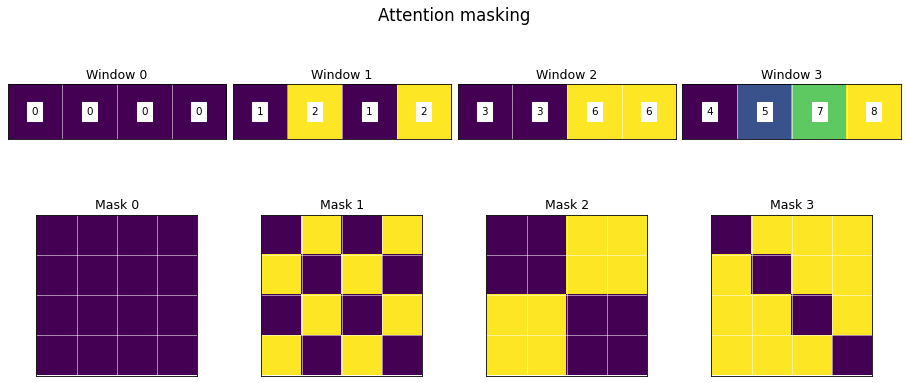

In [7]:
figsize = (12, 5)
fig = plt.figure(constrained_layout=True, figsize=figsize, dpi=dpi)
fig.suptitle("Attention masking", fontsize=fontsize_figure)
gs = fig.add_gridspec(2, hdm * wdm)

for i in range(hdm * wdm):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(id_windows[i].view(1, hm * wm).detach().numpy())
    ax.set_title(f"Window {i}")
    ax.set_xticks([])
    ax.set_yticks([])
    for j in range(hm * wm):
        ax.axvline(j - 0.5, color="#fff", linewidth=0.5)
        text = ax.text(j, 0, f"{int(id_windows[i][j])}", ha="center", va="center", color="black")
        text.set_backgroundcolor("white")


for i in range(hdm * wdm):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(mask[i].detach().numpy())
    ax.set_title(f"Mask {i}")
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(hm * wm):
        ax.axvline(i - 0.5, color="#fff", linewidth=0.5)
        ax.axhline(i - 0.5, color="#fff", linewidth=0.5)


plt.show()
plt.close()

## Relative positional embedding bias

In [8]:
torch.manual_seed(0)

# Parameters of a layer
h, w = (4, 4)
hm, wm = (2, 2)
c = 3 or 1
c_embed = 12
hdm, wdm = h // hm, w // wm
num_heads = 3

# 1. Embedding table for relative distances
#    The maximum relative distance an element can have in a window is the widnow
#    size minus one. Accordingly, to account positive and negative distances, we
#    need to double the maximum distance and add one for the zero distance. This
#    is the number of unique distances an element can have in a window. For each
#    head, we want to have a unique embedding (bias). For instance, if we would
#    context-aware embeddings then the size would be the query-key dimension
#    (d_k).
max_distance = (hm - 1, wm - 1)
embedding_table = nn.Embedding(sum(2 * d + 1 for d in max_distance), num_heads)

# 2. Offsets
#    I decided to have a bias for each dimension too. Meaning, the number of
#    embeddings is twice as large. Later, to get the correct indices, we need to
#    add the offsets to the relative distance (indices).
offsets = [0] + list(itertools.accumulate((2 * d + 1 for d in max_distance[:-1])))

# 3. Absolute distances
#    The absolute distances are the same for each window and can be precomputed.
#    Note that we flatten the tensors as these are the relative distances for
#    each element in a sequence (window is linearised).
#    
#    >>> h_abs_dist = [     >>> w_abs_dist = [
#    >>>     [0, 0],        >>>     [0, 1],
#    >>>     [1, 1],        >>>     [0, 1],
#    >>> ]                  >>> ]
#
#    >>> h_abs_dist.flatten() = [0, 0, 1, 1]
#    >>> w_abs_dist.flatten() = [0, 1, 0, 1]
#    
h_abs_dist = torch.arange(hm)
w_abs_dist = torch.arange(wm)
h_abs_dist = einops.repeat(h_abs_dist, "p -> p wm", wm=hm).flatten()
w_abs_dist = einops.repeat(w_abs_dist, "p -> hm p", hm=wm).flatten()

# 4. Relative distances
#    We rearrange the tensors to broadcast the substraction (see attention mask)
#    to get the relative distances for each element in a sequence.
#
#    >>> h_rel_dist = [         >>> w_rel_dist = [
#    >>>     [ 0, 0, 1, 1],     >>>     [ 0, 1,  0, 1],
#    >>>     [ 0, 0, 1, 1],     >>>     [-1, 0, -1, 0],
#    >>>     [-1,-1, 0, 0],     >>>     [ 0, 1,  0, 1],
#    >>>     [-1,-1, 0, 0],     >>>     [-1, 0, -1, 0],
#    >>> ]                      >>> ]
h_rel_dist = h_abs_dist.unsqueeze(0) - h_abs_dist.unsqueeze(1)
w_rel_dist = w_abs_dist.unsqueeze(0) - w_abs_dist.unsqueeze(1)

# 5. Indices
#    To get valid indices for the embedding table, we need to clamp and shift 
#    the relative distances. The clamping is necessary to avoid out-of-bounds
#    errors. The shifting is necessary to get positive indices. Remmeber, the
#    embedding table has biases for both axis, therefore, we need to add the
#    offsets to the indices.
h_idx = torch.clamp(h_rel_dist, -max_distance[0], max_distance[0]) + max_distance[0] + offsets[0]
w_idx = torch.clamp(w_rel_dist, -max_distance[1], max_distance[1]) + max_distance[1] + offsets[1]

indices = torch.stack([h_idx, w_idx])
biases = embedding_table(indices)
embed = biases.sum(0)

print("Paramters")
print(f"'2 (hm wm) (hm wm)' = {tuple(indices.shape)}")
print(f"'i nh' = {tuple(embedding_table.weight.shape)}")
print(f"'2 (hm wm) (hm wm) nh' = {tuple(biases.shape)}")
print(f"'(hm wm) (hm wm) nh' = {tuple(embed.shape)}")

Paramters
'2 (hm wm) (hm wm)' = (2, 4, 4)
'i nh' = (6, 3)
'2 (hm wm) (hm wm) nh' = (2, 4, 4, 3)
'(hm wm) (hm wm) nh' = (4, 4, 3)
